
# Bank Marketing — Pré-processamento e Clusterização

Este notebook conduz um fluxo completo de pré processamento e clusterização para o dataset **Bank Marketing (UCI)**:
1) **Carregamento e checagens iniciais**  
2) **Limpeza e engenharia de variáveis** (flags de cancelamento/ajuste, valor por linha, etc.)  

> Observações
> - Os métodos de clustering normalmente usam métricas que envolvem distância e minimiza a variância intra-cluster; por isso precisamos **padronizar** as features.  

Link de acesso ao dataset: https://archive.ics.uci.edu/dataset/222/bank+marketing

In [1]:
#Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import os
import sys
import pandas as pd
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src'))
sys.path.append(src_path)
from dbscan import DBSCAN
from kmeans import KMeans
from kmedoids import KMedoids
from wardmethod import WardMethod
from expectationmaximization import ExpectationMaximization
import distance_metrics
from evaluationmetrics import EvaluationMetrics
from func_auxiliar import plot_algorithm_all_metrics, calculate_clustering_metrics, generate_synthetic_blobs, plot_algorithm_all_metrics_3d, plot_melhor_k_silhouette_and_sse, to_probability_simplex

In [2]:

FILE_PATH = "/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/data/DatasetRaw/bank-marketing/bank.csv"

# Leitura do CSV com separador ;
df = pd.read_csv(FILE_PATH, sep=";")

# Selecionar apenas as colunas esperadas
expected_cols = ['age','job','marital','education','default','balance','housing','loan',
                 'contact','day','month','duration','campaign','pdays','previous','poutcome','y']
df = df[expected_cols]

df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
# 1) Remover duplicados (por segurança)
df = df.drop_duplicates()

# 2) Garantir que as colunas numéricas importantes são numéricas mesmo
num_cols = ["balance", "campaign", "pdays", "previous"]

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 3) Dropar linhas onde alguma dessas colunas ficou NaN (caso o arquivo venha sujo)
df = df.dropna(subset=num_cols)

In [4]:
# Confirma qual é o valor de "nunca contatado" (geralmente 999 no UCI original, as vezes -1 em versões tratadas)
valor_nunca_contatado = -1 
if 999 in df['pdays'].unique():
    valor_nunca_contatado = 999

valor_nunca_contatado

-1

In [5]:
df_experiment = df.copy()

In [6]:
# flag: já tinha sido contatado em campanhas anteriores?
df_experiment["was_contacted_before"] = (df_experiment["pdays"] != -1).astype(int)

In [7]:
# pega só quem tem pdays "real"
mask_contacted = df_experiment["pdays"] != -1
max_real_pdays = df_experiment.loc[mask_contacted, "pdays"].max()

In [8]:
# Recência de contato:
# - quem nunca foi contatado recebe max_real_pdays + 1 (mais "antigo" que todos)
df_experiment["Recency"] = np.where(
    df_experiment["pdays"] == -1,
    max_real_pdays + 1,
    df_experiment["pdays"]
)

In [9]:
df_experiment["Frequency"] = df_experiment["campaign"] + df_experiment["previous"]

In [10]:
min_balance = df_experiment["balance"].min()
shift = -min_balance + 1 if min_balance <= 0 else 0

df_experiment["balance_shifted"] = df_experiment["balance"] + shift
df_experiment["M_balance"] = np.log1p(df_experiment["balance_shifted"])
df_experiment.drop(columns=["balance_shifted"], inplace=True)

In [11]:
rfm= df_experiment[["Recency", "Frequency", "M_balance"]].copy()
rfm.head()

,Recency,Frequency,M_balance
0,872,1,8.537388
1,339,5,9.000113
2,330,2,8.447843
3,872,4,8.474494
4,872,1,8.106213


In [12]:
scaler = MinMaxScaler()
df_scalar = scaler.fit_transform(rfm)

X = pd.DataFrame(
    df_scalar,
    columns=["R_norm", "F_norm", "M_norm"],
    index=df_experiment.index
)
X.head()

,R_norm,F_norm,M_norm
0,1.000000,0.000000,0.745264
1,0.388060,0.081633,0.789227
2,0.377727,0.020408,0.736757
3,1.000000,0.061224,0.739289
4,1.000000,0.000000,0.704299


In [13]:
rfm_full = (
    rfm
    .join(X)  # adiciona Recency_scaled, Frequency_scaled, Monetary_scaled
    .join(df_experiment["y"].map({"no": 0, "yes": 1}))  # adiciona a coluna alvo 'y'
    .join(df_experiment["age"].astype(int))  # adiciona a coluna de idade
    .join(df_experiment["housing"].map({"no": 0, "yes": 1}))
    .join(df_experiment["marital"])
    .join(df_experiment["education"])
)

rfm_full.head()

,Recency,Frequency,M_balance,R_norm,F_norm,M_norm,y,age,housing,marital,education
0,872,1,8.537388,1.000000,0.000000,0.745264,0,30,0,married,primary
1,339,5,9.000113,0.388060,0.081633,0.789227,0,33,1,married,secondary
2,330,2,8.447843,0.377727,0.020408,0.736757,0,35,1,single,tertiary
3,872,4,8.474494,1.000000,0.061224,0.739289,0,30,1,married,tertiary
4,872,1,8.106213,1.000000,0.000000,0.704299,0,59,1,married,secondary


In [14]:
X_jsd = to_probability_simplex(X)

In [124]:
#Estudo do melhor k para K-Means
results_k = []
from sklearn.metrics import silhouette_score
for k in range(2, 11):
    kmeans = KMeans(k=k, max_iterations=300, metric_name='euclidean_distance')
    centroids_kmeans, clusters_kmeans = kmeans.fit(X)
    diffs = (X - centroids_kmeans[clusters_kmeans]) ** 2
    sse = diffs.sum(axis=0).sum()
    sil = silhouette_score(X, clusters_kmeans)
    results_k.append({"k": k,
        "sse_euclidean": sse,
        "silhouette": sil,
        "algoritmo": "K-Means"
    })
    

Convergiu na iteração 4
Convergiu na iteração 4
Convergiu na iteração 12
Convergiu na iteração 9
Convergiu na iteração 42
Convergiu na iteração 23
Convergiu na iteração 24
Convergiu na iteração 14
Convergiu na iteração 24


In [ ]:
df_k_search = pd.DataFrame(results_k)
df_k_search

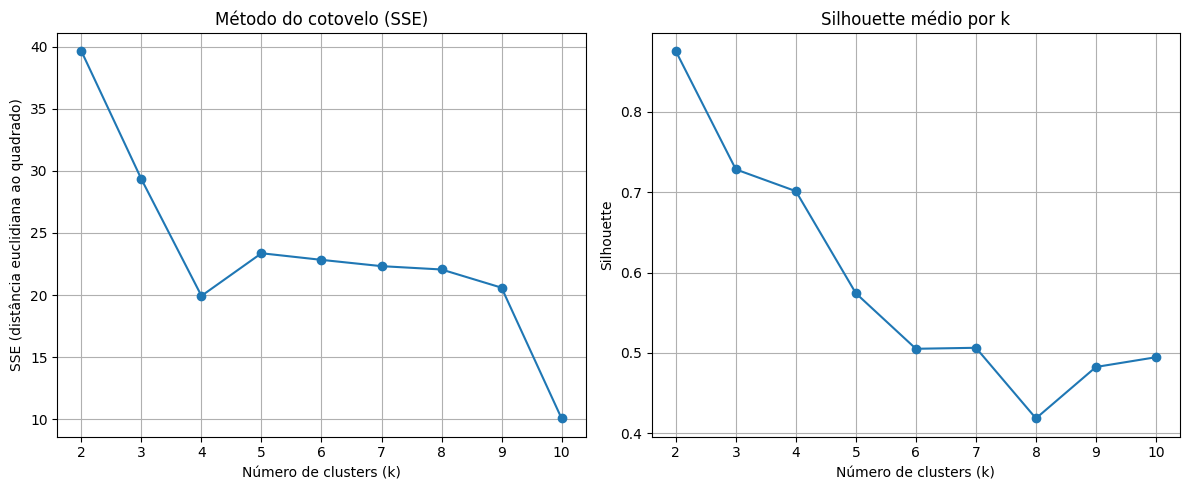

In [17]:
plot_melhor_k_silhouette_and_sse(df_k_search[df_k_search['algoritmo'] == 'K-Means'])

In [ ]:
#Estudo do melhor k para K-medoids
from sklearn.metrics import silhouette_score
for k in range(2, 11):
    kmedoids = KMedoids(k=k, max_iterations=300, metric_name='euclidean_distance')
    centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
    diffs = (X - centroids_kmedoids[clusters_kmedoids]) ** 2
    sse = diffs.sum(axis=0).sum()
    sil = silhouette_score(X, clusters_kmedoids)
    results_k.append({"k": k,
        "sse_euclidean": sse,
        "silhouette": sil,
        "algoritmo": "K-Medoids"
    })
    print(f"Completed k={k} for K-Medoids")
    

In [21]:
df_k_search = pd.DataFrame(results_k)
df_k_search

,k,sse_euclidean,silhouette,algoritmo
0,2,39.649049,0.875366,K-Means
1,3,29.331918,0.728302,K-Means
2,4,19.932781,0.701207,K-Means
3,5,23.367989,0.574141,K-Means
4,6,22.834767,0.505141,K-Means
5,7,22.328251,0.506375,K-Means
6,8,22.059292,0.418569,K-Means
7,9,20.593156,0.482502,K-Means
8,10,10.062839,0.494640,K-Means
9,2,41.520013,0.875366,K-Medoids


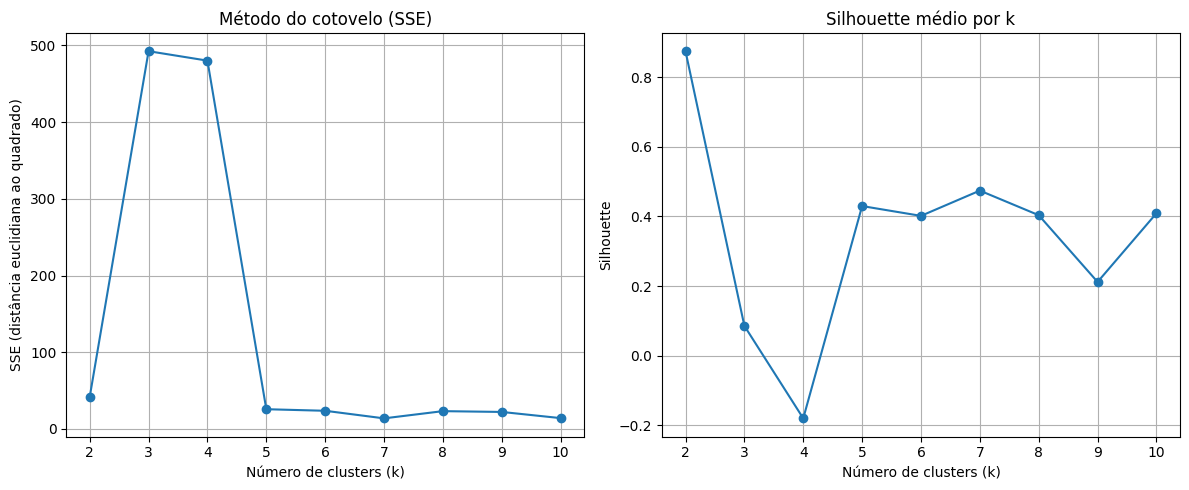

In [22]:
plot_melhor_k_silhouette_and_sse(df_k_search[df_k_search['algoritmo'] == 'K-Medoids'])

### Algoritmo: Kmeans

In [17]:
metrics = ['euclidean_distance', 'manhattan_distance', 'cosine_distance', 'mahalanobis_distance', 'jensen-shannon_distance']



In [ ]:
results_kmeans = []
plots_kmeans = {}
# instaciando o KMeans
for metric_name in metrics:
    kmeans = KMeans(k=2, max_iterations=1000, metric_name=metric_name)
    if metric_name == 'jensen-shannon_distance':
        t0 = time()
        centroids_kmeans, clusters_kmeans = kmeans.fit(X_jsd)
        runtime_kmeans = abs(time() - t0)
        results_kmeans.append(calculate_clustering_metrics(algorithm_name="Kmeans", metric_name=metric_name, runtime=runtime_kmeans, X=X_jsd, labels=clusters_kmeans))
        plots_kmeans[metric_name] = {
            "X": X_jsd,
            "labels": clusters_kmeans,
            "model": kmeans
        }
    else:
        t0 = time()
        centroids_kmeans, clusters_kmeans = kmeans.fit(X)
        runtime_kmeans = time() - t0
        results_kmeans.append(calculate_clustering_metrics(algorithm_name="Kmeans", metric_name=metric_name, runtime=runtime_kmeans, X=X, labels=clusters_kmeans))
        plots_kmeans[metric_name] = {
            "X": X,
            "labels": clusters_kmeans,
            "model": kmeans
        }
    
    print(f"KMeans com {metric_name} finalizado.")


Convergiu na iteração 2
KMeans com euclidean_distance finalizado.
Convergiu na iteração 7
KMeans com manhattan_distance finalizado.
Convergiu na iteração 5
KMeans com cosine_distance finalizado.
Convergiu na iteração 24
KMeans com mahalanobis_distance finalizado.
Convergiu na iteração 4
KMeans com jensen-shannon_distance finalizado.


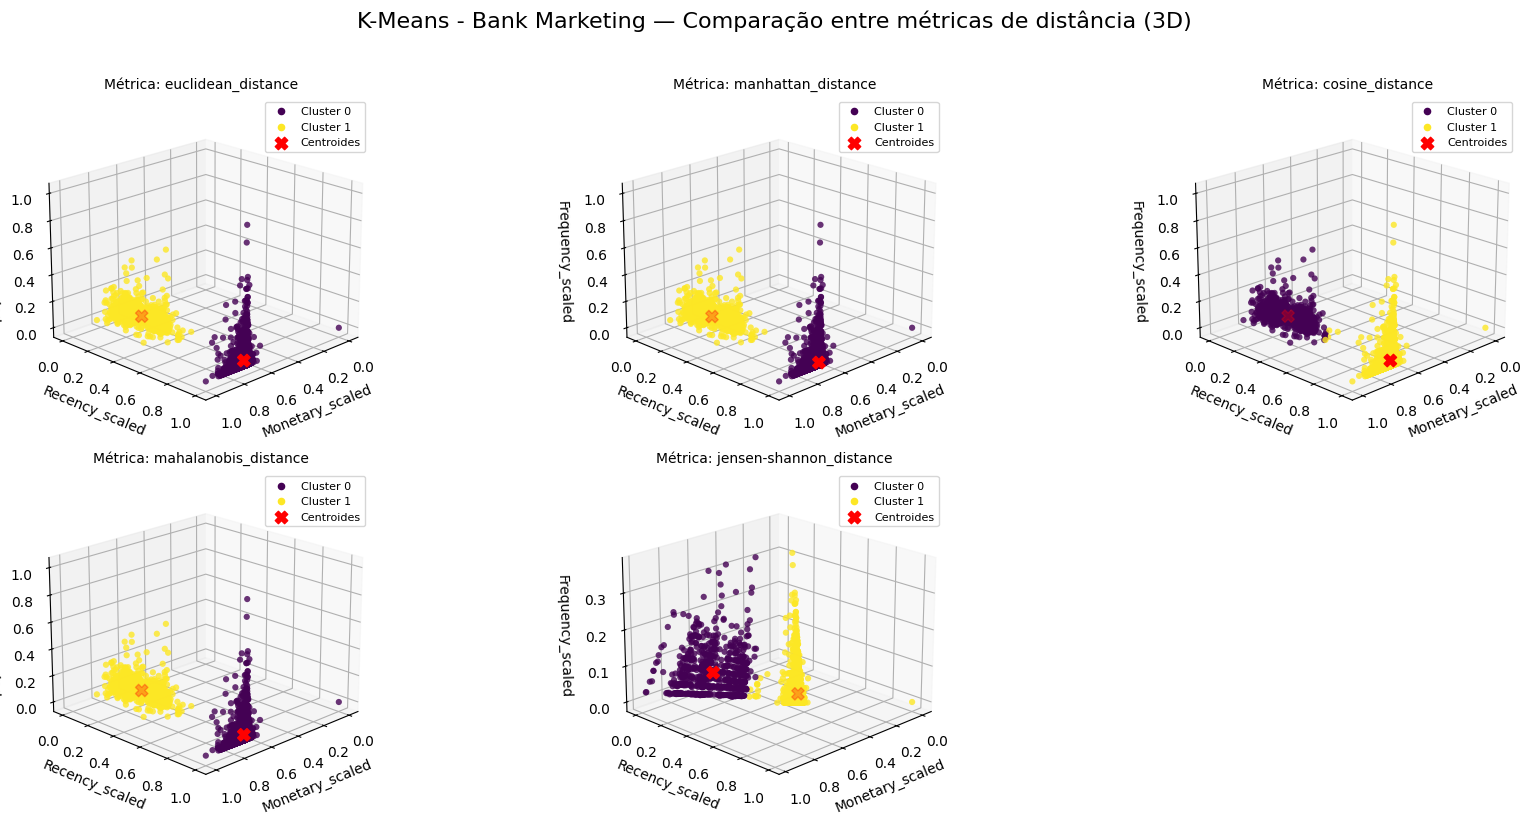

In [60]:
plot_algorithm_all_metrics_3d(plot_dict=plots_kmeans, algorithm_name="K-Means - Bank Marketing", x_index=2, y_index=0, z_index=1,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [59]:
#results_kmeans.pop()
df_results_kmeans = pd.DataFrame(results_kmeans)
df_results_kmeans

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,Kmeans,euclidean_distance,2,0.131907,39.649049,0.875366,0.245667,42491.989427
1,Kmeans,cosine_distance,2,0.569681,39.995147,0.874808,0.244498,42085.179693
2,Kmeans,jensen-shannon_distance,2,2.144498,41.168025,0.872978,0.242966,40757.424904
3,Kmeans,mahalanobis_distance,2,0.405209,39.649049,0.875366,0.245667,42491.989427
4,Kmeans,manhattan_distance,2,0.176062,39.649049,0.875366,0.245667,42491.989427


In [61]:
labels_k_means_euclidean = plots_kmeans['euclidean_distance']["labels"]
labels_k_means_manhattan = plots_kmeans['manhattan_distance']["labels"]
labels_k_means_cosine = plots_kmeans['cosine_distance']["labels"]
labels_k_means_mahalanobis = plots_kmeans['mahalanobis_distance']["labels"]
labels_k_means_jsd = plots_kmeans['jensen-shannon_distance']["labels"]

rfm_k_means = rfm_full.copy()
rfm_k_means[f"cluster_k_means_euclidean"] = labels_k_means_euclidean
rfm_k_means[f"cluster_k_means_manhattan"] = labels_k_means_manhattan
rfm_k_means[f"cluster_k_means_cosine"] = labels_k_means_cosine
rfm_k_means[f"cluster_k_means_mahalanobis"] = labels_k_means_mahalanobis
rfm_k_means[f"cluster_k_means_jsd"] = labels_k_means_jsd
rfm_k_means.head()

,Recency,Frequency,M_balance,R_norm,F_norm,M_norm,y,age,housing,marital,education,cluster_k_means_euclidean,cluster_k_means_manhattan,cluster_k_means_cosine,cluster_k_means_mahalanobis,cluster_k_means_jsd
0,872,1,8.537388,1.000000,0.000000,0.745264,0,30,0,married,primary,0,0,1,0,1
1,339,5,9.000113,0.388060,0.081633,0.789227,0,33,1,married,secondary,1,1,0,1,0
2,330,2,8.447843,0.377727,0.020408,0.736757,0,35,1,single,tertiary,1,1,0,1,0
3,872,4,8.474494,1.000000,0.061224,0.739289,0,30,1,married,tertiary,0,0,1,0,1
4,872,1,8.106213,1.000000,0.000000,0.704299,0,59,1,married,secondary,0,0,1,0,1


In [62]:
cluster_profile_kmeans_euclidean = (
    rfm_k_means
    .groupby("cluster_k_means_euclidean")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_kmeans_euclidean["perc_contatos"] = (
    cluster_profile_kmeans_euclidean["n_contatos"]
    / cluster_profile_kmeans_euclidean["n_contatos"].sum()
)

cluster_profile_kmeans_euclidean["perc_potencial"] = (
    cluster_profile_kmeans_euclidean["potencial_total"]
    / cluster_profile_kmeans_euclidean["potencial_total"].sum()
)

cluster_profile_kmeans_euclidean


,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_means_euclidean,,,,,,,,,,,,
1,809,220.274413,188.0,5.019778,4.0,8.409806,8.279951,6803.533296,0.223733,0.632880,0.178943,0.179838
0,3712,871.780172,872.0,2.969289,2.0,8.358822,8.224298,31027.949094,0.091595,0.551455,0.821057,0.820162


In [63]:
cluster_profile_k_means_manhattan = (
    rfm_k_means
    .groupby(f"cluster_k_means_manhattan")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_manhattan["perc_contatos"] = (
    cluster_profile_k_means_manhattan["n_contatos"]
    / cluster_profile_k_means_manhattan["n_contatos"].sum()
)

cluster_profile_k_means_manhattan["perc_potencial"] = (
    cluster_profile_k_means_manhattan["potencial_total"]
    / cluster_profile_k_means_manhattan["potencial_total"].sum()
)

cluster_profile_k_means_manhattan

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_means_manhattan,,,,,,,,,,,,
1,809,220.274413,188.0,5.019778,4.0,8.409806,8.279951,6803.533296,0.223733,0.632880,0.178943,0.179838
0,3712,871.780172,872.0,2.969289,2.0,8.358822,8.224298,31027.949094,0.091595,0.551455,0.821057,0.820162


In [64]:
cluster_profile_k_means_mahalanobis = (
    rfm_k_means
    .groupby(f"cluster_k_means_mahalanobis")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_mahalanobis["perc_contatos"] = (
    cluster_profile_k_means_mahalanobis["n_contatos"]
    / cluster_profile_k_means_mahalanobis["n_contatos"].sum()
)

cluster_profile_k_means_mahalanobis["perc_potencial"] = (
    cluster_profile_k_means_mahalanobis["potencial_total"]
    / cluster_profile_k_means_mahalanobis["potencial_total"].sum()
)

cluster_profile_k_means_mahalanobis

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_means_mahalanobis,,,,,,,,,,,,
1,809,220.274413,188.0,5.019778,4.0,8.409806,8.279951,6803.533296,0.223733,0.632880,0.178943,0.179838
0,3712,871.780172,872.0,2.969289,2.0,8.358822,8.224298,31027.949094,0.091595,0.551455,0.821057,0.820162


In [65]:
cluster_profile_k_means_cosine = (
    rfm_k_means
    .groupby(f"cluster_k_means_cosine")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_cosine["perc_contatos"] = (
    cluster_profile_k_means_cosine["n_contatos"] 
    / cluster_profile_k_means_cosine["n_contatos"].sum()
)

cluster_profile_k_means_cosine["perc_potencial"] = (
    cluster_profile_k_means_cosine["potencial_total"] 
    / cluster_profile_k_means_cosine["potencial_total"].sum()
)

cluster_profile_k_means_cosine

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_means_cosine,,,,,,,,,,,,
0,805,218.908075,188.0,5.024845,4.0,8.409926,8.279951,6769.990801,0.222360,0.633540,0.178058,0.178951
1,3716,871.374865,872.0,2.970398,2.0,8.358851,8.224432,31061.491590,0.092034,0.551399,0.821942,0.821049


In [66]:
cluster_profile_k_means_jsd = (
    rfm_k_means
    .groupby(f"cluster_k_means_jsd")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_means_jsd["perc_contatos"] = (
    cluster_profile_k_means_jsd["n_contatos"] 
    / cluster_profile_k_means_jsd["n_contatos"].sum()
)

cluster_profile_k_means_jsd["perc_potencial"] = (
    cluster_profile_k_means_jsd["potencial_total"] 
    / cluster_profile_k_means_jsd["potencial_total"].sum()
)

cluster_profile_k_means_jsd

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_means_jsd,,,,,,,,,,,,
0,797,216.506901,186.0,5.046424,4.0,8.408921,8.278428,6701.909932,0.218319,0.633626,0.176288,0.177152
1,3724,870.487111,872.0,2.970193,2.0,8.359176,8.224967,31129.572459,0.093179,0.551557,0.823712,0.822848


### Algoritmo: Kmedoids

In [68]:
results_kmedoids = []
plots_kmedoids = {}
# instaciando o KMedoids
for metric_name in metrics:
    kmedoids = KMedoids(k=2, max_iterations=300, metric_name=metric_name)
    if metric_name == 'jensen-shannon_distance':
        t0 = time()
        centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X_jsd)
        runtime_kmedoids = time() - t0
        results_kmedoids.append(calculate_clustering_metrics(algorithm_name="KMedoids", metric_name=metric_name, runtime=runtime_kmedoids, X=X_jsd, labels=clusters_kmedoids))
        plots_kmedoids[metric_name] = {
            "X": X_jsd,
            "labels": clusters_kmedoids,
            "model": kmedoids
        }
    else:
        t0 = time()
        centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
        runtime_kmedoids = time() - t0
        results_kmedoids.append(calculate_clustering_metrics(algorithm_name="KMedoids", metric_name=metric_name, runtime=runtime_kmedoids, X=X, labels=clusters_kmedoids))
        plots_kmedoids[metric_name] = {
            "X": X,
            "labels": clusters_kmedoids,
            "model": kmedoids
        }
    
    print(f"KMedoids com {metric_name} finalizado.")


K-Medoids convergiu na iteração 5
KMedoids com euclidean_distance finalizado.
K-Medoids convergiu na iteração 4
KMedoids com manhattan_distance finalizado.
K-Medoids convergiu na iteração 5
KMedoids com cosine_distance finalizado.
K-Medoids convergiu na iteração 6
KMedoids com mahalanobis_distance finalizado.
K-Medoids convergiu na iteração 3
KMedoids com jensen-shannon_distance finalizado.


In [97]:
kmedoids = KMedoids(k=2, max_iterations=1000, metric_name='euclidean_distance')
t0 = time()
centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
runtime_kmedoids = time() - t0
results_kmedoids.append(calculate_clustering_metrics(algorithm_name="KMedoids", metric_name='euclidean_distance', runtime=runtime_kmedoids, X=X, labels=clusters_kmedoids))
plots_kmedoids['euclidean_distance'] = {
    "X": X,
    "labels": clusters_kmedoids,
    "model": kmedoids
}

K-Medoids convergiu na iteração 2


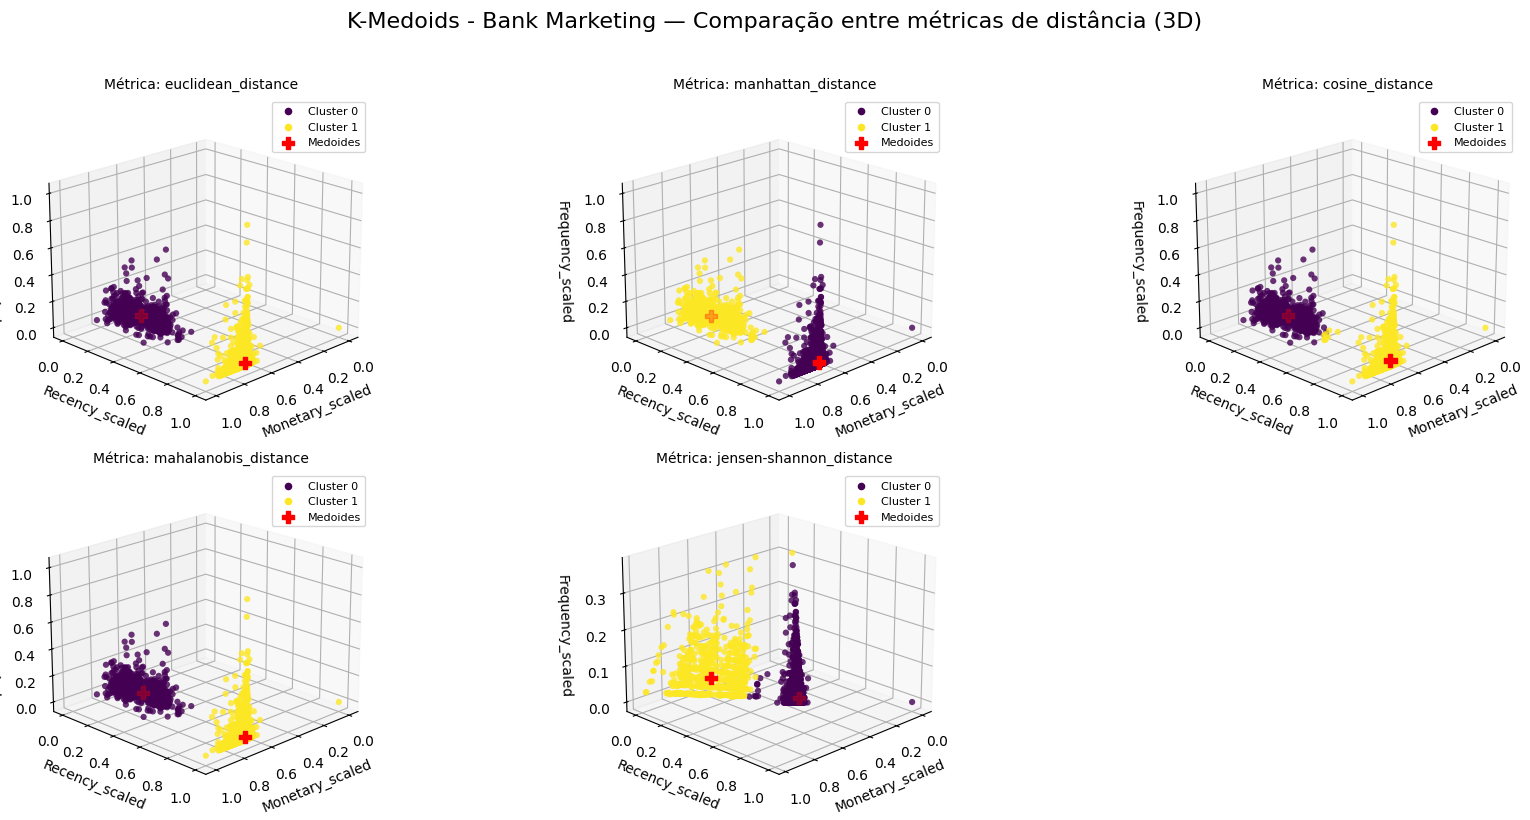

In [98]:
plot_algorithm_all_metrics_3d(plot_dict=plots_kmedoids, algorithm_name="K-Medoids - Bank Marketing", x_index=2, y_index=0, z_index=1,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [102]:
#results_kmedoids.pop()
df_results_kmedoids = pd.DataFrame(results_kmedoids)
df_results_kmedoids

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,KMedoids,cosine_distance,2,533.517964,40.480901,0.874025,0.243568,41525.948687
1,KMedoids,jensen-shannon_distance,2,2110.487824,23.230660,0.848924,0.347661,25804.785854
2,KMedoids,manhattan_distance,2,117.884543,39.649049,0.875366,0.245667,42491.989427
3,KMedoids,mahalanobis_distance,2,188.853851,39.649049,0.875366,0.245667,42491.989427
4,KMedoids,euclidean_distance,2,93.406989,39.649049,0.875366,0.245667,42491.989427


In [103]:
labels_k_medoids_euclidean = plots_kmedoids['euclidean_distance']["labels"]
labels_k_medoids_manhattan = plots_kmedoids['manhattan_distance']["labels"]
labels_k_medoids_cosine = plots_kmedoids['cosine_distance']["labels"]
labels_k_medoids_mahalanobis = plots_kmedoids['mahalanobis_distance']["labels"]
labels_k_medoids_jsd = plots_kmedoids['jensen-shannon_distance']["labels"]

rfm_k_medoids = rfm_full.copy()
rfm_k_medoids[f"cluster_k_medoids_euclidean"] = labels_k_medoids_euclidean
rfm_k_medoids[f"cluster_k_medoids_manhattan"] = labels_k_medoids_manhattan
rfm_k_medoids[f"cluster_k_medoids_cosine"] = labels_k_medoids_cosine
rfm_k_medoids[f"cluster_k_medoids_mahalanobis"] = labels_k_medoids_mahalanobis
rfm_k_medoids[f"cluster_k_medoids_jsd"] = labels_k_medoids_jsd
rfm_k_medoids.head()



,Recency,Frequency,M_balance,R_norm,F_norm,M_norm,y,age,housing,marital,education,cluster_k_medoids_euclidean,cluster_k_medoids_manhattan,cluster_k_medoids_cosine,cluster_k_medoids_mahalanobis,cluster_k_medoids_jsd
0,872,1,8.537388,1.000000,0.000000,0.745264,0,30,0,married,primary,1,0,1,1,0
1,339,5,9.000113,0.388060,0.081633,0.789227,0,33,1,married,secondary,0,1,0,0,1
2,330,2,8.447843,0.377727,0.020408,0.736757,0,35,1,single,tertiary,0,1,0,0,1
3,872,4,8.474494,1.000000,0.061224,0.739289,0,30,1,married,tertiary,1,0,1,1,0
4,872,1,8.106213,1.000000,0.000000,0.704299,0,59,1,married,secondary,1,0,1,1,0


In [104]:
cluster_profile_k_medoids_euclidean = (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_euclidean")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_euclidean["perc_contatos"] = (
    cluster_profile_k_medoids_euclidean["n_contatos"] 
    / cluster_profile_k_medoids_euclidean["n_contatos"].sum()
)

cluster_profile_k_medoids_euclidean["perc_potencial"] = (
    cluster_profile_k_medoids_euclidean["potencial_total"] 
    / cluster_profile_k_medoids_euclidean["potencial_total"].sum()
)

cluster_profile_k_medoids_euclidean

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_medoids_euclidean,,,,,,,,,,,,
0,809,220.274413,188.0,5.019778,4.0,8.409806,8.279951,6803.533296,0.223733,0.632880,0.178943,0.179838
1,3712,871.780172,872.0,2.969289,2.0,8.358822,8.224298,31027.949094,0.091595,0.551455,0.821057,0.820162


In [105]:
cluster_profile_k_medoids_manhattan = (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_manhattan")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_manhattan["perc_contatos"] = (
    cluster_profile_k_medoids_manhattan["n_contatos"] 
    / cluster_profile_k_medoids_manhattan["n_contatos"].sum()
)

cluster_profile_k_medoids_manhattan["perc_potencial"] = (
    cluster_profile_k_medoids_manhattan["potencial_total"] 
    / cluster_profile_k_medoids_manhattan["potencial_total"].sum()
)

cluster_profile_k_medoids_manhattan

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_medoids_manhattan,,,,,,,,,,,,
1,809,220.274413,188.0,5.019778,4.0,8.409806,8.279951,6803.533296,0.223733,0.632880,0.178943,0.179838
0,3712,871.780172,872.0,2.969289,2.0,8.358822,8.224298,31027.949094,0.091595,0.551455,0.821057,0.820162


In [106]:
cluster_profile_k_medoids_cosine = (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_cosine")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_cosine["perc_contatos"] = (
    cluster_profile_k_medoids_cosine["n_contatos"] 
    / cluster_profile_k_medoids_cosine["n_contatos"].sum()
)

cluster_profile_k_medoids_cosine["perc_potencial"] = (
    cluster_profile_k_medoids_cosine["potencial_total"] 
    / cluster_profile_k_medoids_cosine["potencial_total"].sum()
)

cluster_profile_k_medoids_cosine

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_medoids_cosine,,,,,,,,,,,,
0,801,217.637953,187.0,5.034956,4.0,8.409264,8.278682,6735.820470,0.219725,0.632959,0.177173,0.178048
1,3720,870.946774,872.0,2.970430,2.0,8.359049,8.224700,31095.661921,0.092742,0.551613,0.822827,0.821952


In [107]:
cluster_profile_k_medoids_mahalanobis= (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_mahalanobis")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_mahalanobis["perc_contatos"] = (
    cluster_profile_k_medoids_mahalanobis["n_contatos"] 
    / cluster_profile_k_medoids_mahalanobis["n_contatos"].sum()
)

cluster_profile_k_medoids_mahalanobis["perc_potencial"] = (
    cluster_profile_k_medoids_mahalanobis["potencial_total"] 
    / cluster_profile_k_medoids_mahalanobis["potencial_total"].sum()
)

cluster_profile_k_medoids_mahalanobis

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_medoids_mahalanobis,,,,,,,,,,,,
0,809,220.274413,188.0,5.019778,4.0,8.409806,8.279951,6803.533296,0.223733,0.632880,0.178943,0.179838
1,3712,871.780172,872.0,2.969289,2.0,8.358822,8.224298,31027.949094,0.091595,0.551455,0.821057,0.820162


In [108]:
cluster_profile_k_medoids_jsd = (
    rfm_k_medoids
    .groupby(f"cluster_k_medoids_jsd")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_k_medoids_jsd["perc_contatos"] = (
    cluster_profile_k_medoids_jsd["n_contatos"] 
    / cluster_profile_k_medoids_jsd["n_contatos"].sum()
)

cluster_profile_k_medoids_jsd["perc_potencial"] = (
    cluster_profile_k_medoids_jsd["potencial_total"] 
    / cluster_profile_k_medoids_jsd["potencial_total"].sum()
)

cluster_profile_k_medoids_jsd


,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_k_medoids_jsd,,,,,,,,,,,,
1,799,217.575720,187.0,5.100125,4.0,8.408512,8.278428,6718.400983,0.219024,0.634543,0.176731,0.177588
0,3722,870.609081,872.0,2.957550,2.0,8.359237,8.224967,31113.081407,0.092961,0.551316,0.823269,0.822412


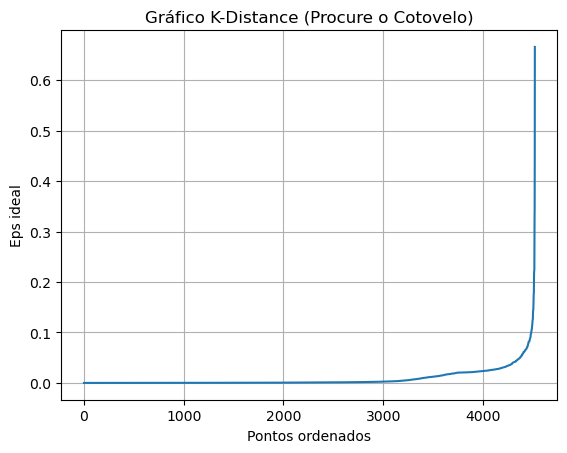

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Calcula a distância para o vizinho mais próximo (k=min_samples)
min_samples = 10 # Mesmo valor que você usará no DBSCAN
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Ordena e plota
distances = np.sort(distances[:, min_samples-1], axis=0)
plt.plot(distances)
plt.title("Gráfico K-Distance (Procure o Cotovelo)")
plt.ylabel("Eps ideal")
plt.xlabel("Pontos ordenados")
plt.grid(True)
plt.show()

/root/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


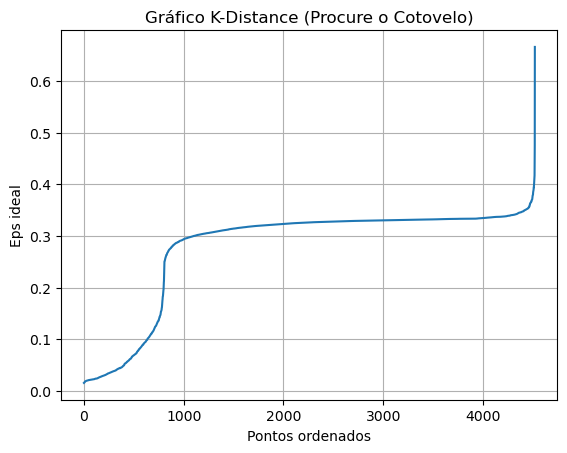

In [ ]:
# Calcula a distância para o vizinho mais próximo (k=min_samples)
min_samples = 10 # Mesmo valor que você usará no DBSCAN
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X_jsd)

# Ordena e plota
distances = np.sort(distances[:, min_samples-1], axis=0)
plt.plot(distances)
plt.title("Gráfico K-Distance (Procure o Cotovelo)")
plt.ylabel("Eps ideal")
plt.xlabel("Pontos ordenados")
plt.grid(True)
plt.show()

In [ ]:
#Estudo do melhor eps para DBSCAN com Euclidean Distance

eval_kwargs = {}
eps = eps = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65]
results_eps = []
for ep in eps:
    db = DBSCAN(eps=ep, min_samples=10, metric='euclidean_distance')
    db.fit(X)
    k = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    dataset = pd.concat(
            [pd.DataFrame(X), pd.DataFrame(db.labels_, columns=['cluster'])],
            axis=1
        )
    # filtra fora os outliers (cluster == -1)
    dataset_filtrado = dataset[dataset['cluster'] != -1]
    # separa X e y já sem ruído
    X_inliers = np.asarray(dataset_filtrado.drop(columns=['cluster']))
    eval_kwargs = {}
    evaluation = EvaluationMetrics(X=X_inliers, labels=np.asarray(dataset_filtrado['cluster']), y_true=None, metric='euclidean', **eval_kwargs)
    sil = evaluation.silhouette()
    sse = evaluation.sse_euclidean()
    results_eps.append({"k": k,
        "sse_euclidean": sse,
        "silhouette": sil,
        "algoritmo": "DBSCAN",
        "eps": ep,
        "metric": "euclidean_distance"
    })
    print(f"DBSCAN com eps {ep} finalizado.")

In [ ]:
results_dbscan = []
plots_dbscan = {}

### Algoritmo: DBSCAN

In [ ]:
# instaciando o DBSCAN
for metric_name in metrics:
    if metric_name == 'jensen-shannon_distance':
        dbscan = DBSCAN(eps=0.03, min_samples=10, metric=metric_name)
        t0 = time()
        dbscan.fit(X_jsd)
        runtime_dbscan = time() - t0
        labels_dbscan = dbscan.labels_
        dataset = pd.concat(
            [pd.DataFrame(X_jsd), pd.DataFrame(labels_dbscan, columns=['cluster'])],
            axis=1
        )
        # filtra fora os outliers (cluster == -1)
        dataset_filtrado = dataset[dataset['cluster'] != -1]
        # separa X e y já sem ruído
        X_inliers = np.asarray(dataset_filtrado.drop(columns=['cluster']))
        labels_inliers = np.asarray(dataset_filtrado['cluster'])
        results_dbscan.append(calculate_clustering_metrics(algorithm_name="DBSCAN", metric_name=metric_name, runtime=runtime_dbscan, X=X_inliers, labels=labels_inliers))
        plots_dbscan[metric_name] = {
            "X": X_jsd,
            "labels": labels_dbscan,
            "model": dbscan
        }
    else:
        dbscan = DBSCAN(eps=0.023, min_samples=10, metric=metric_name)
        t0 = time()
        dbscan.fit(X)
        runtime_dbscan = time() - t0
        labels_dbscan = dbscan.labels_
        dataset = pd.concat(
            [pd.DataFrame(X), pd.DataFrame(labels_dbscan, columns=['cluster'])],
            axis=1
        )
        # filtra fora os outliers (cluster == -1)
        dataset_filtrado = dataset[dataset['cluster'] != -1]
        # separa X e y já sem ruído
        X_inliers = np.asarray(dataset_filtrado.drop(columns=['cluster']))
        labels_inliers = np.asarray(dataset_filtrado['cluster'])
        results_dbscan.append(calculate_clustering_metrics(algorithm_name="DBSCAN", metric_name=metric_name, runtime=runtime_dbscan, X=X_inliers, labels=labels_inliers))
        plots_dbscan[metric_name] = {
            "X": X,
            "labels": labels_dbscan,
            "model": dbscan
        }
    
    print(f"dbscan com {metric_name} finalizado.")

dbscan com mahalanobis_distance finalizado.


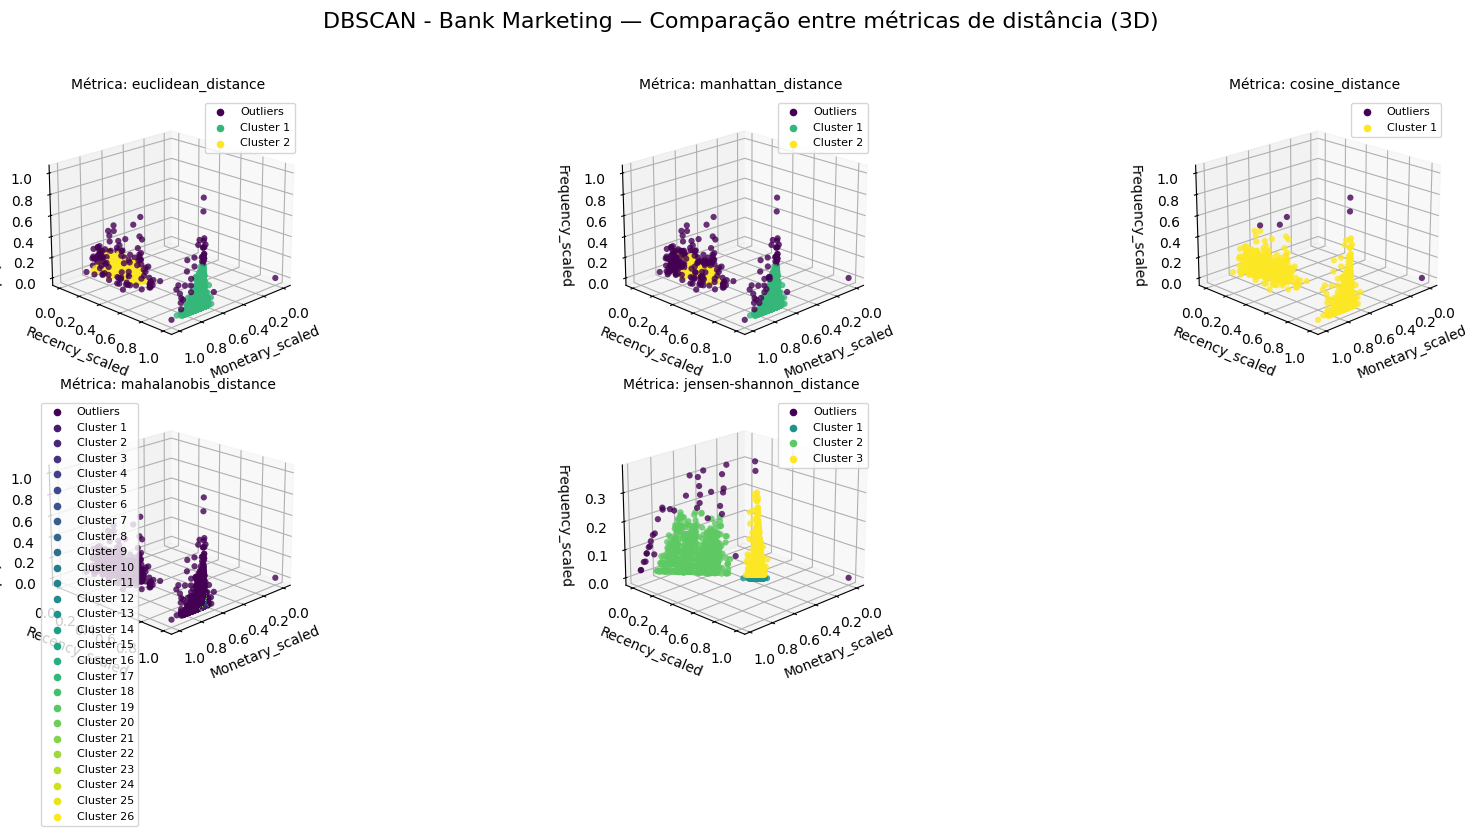

In [155]:
plot_algorithm_all_metrics_3d(plot_dict=plots_dbscan, algorithm_name="DBSCAN - Bank Marketing", x_index=2, y_index=0, z_index=1,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [156]:
#results_dbscan.pop()
df_results_dbscan = pd.DataFrame(results_dbscan)
df_results_dbscan

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,DBSCAN,euclidean_distance,2,166.844210,25.477581,0.891490,0.216314,57020.650002
1,DBSCAN,manhattan_distance,2,209.306743,23.748211,0.894030,0.213086,54650.981257
2,DBSCAN,jensen-shannon_distance,3,1796.529973,18.237690,0.271519,0.841505,15574.840647
3,DBSCAN,cosine_distance,1,309.241724,411.915523,NaN,NaN,NaN
4,DBSCAN,mahalanobis_distance,26,139.819491,0.241315,0.183377,0.419379,875.941051


In [157]:
labels_dbscan_euclidean = plots_dbscan['euclidean_distance']["labels"]
labels_dbscan_manhattan = plots_dbscan['manhattan_distance']["labels"]
labels_dbscan_cosine = plots_dbscan['cosine_distance']["labels"]
labels_dbscan_mahalanobis = plots_dbscan['mahalanobis_distance']["labels"]
labels_dbscan_jsd = plots_dbscan['jensen-shannon_distance']["labels"]

rfm_dbscan = rfm_full.copy()
rfm_dbscan[f"cluster_dbscan_euclidean"] = labels_dbscan_euclidean
rfm_dbscan[f"cluster_dbscan_manhattan"] = labels_dbscan_manhattan
rfm_dbscan[f"cluster_dbscan_cosine"] = labels_dbscan_cosine
rfm_dbscan[f"cluster_dbscan_mahalanobis"] = labels_dbscan_mahalanobis
rfm_dbscan[f"cluster_dbscan_jsd"] = labels_dbscan_jsd
rfm_dbscan.head()


,Recency,Frequency,M_balance,R_norm,F_norm,M_norm,y,age,housing,marital,education,cluster_dbscan_euclidean,cluster_dbscan_manhattan,cluster_dbscan_cosine,cluster_dbscan_mahalanobis,cluster_dbscan_jsd
0,872,1,8.537388,1.000000,0.000000,0.745264,0,30,0,married,primary,1,1,1,1,1
1,339,5,9.000113,0.388060,0.081633,0.789227,0,33,1,married,secondary,-1,-1,1,-1,2
2,330,2,8.447843,0.377727,0.020408,0.736757,0,35,1,single,tertiary,2,2,1,-1,2
3,872,4,8.474494,1.000000,0.061224,0.739289,0,30,1,married,tertiary,1,1,1,-1,3
4,872,1,8.106213,1.000000,0.000000,0.704299,0,59,1,married,secondary,1,1,1,1,1


In [158]:
cluster_profile_dbscan_euclidean = (
    rfm_dbscan
    .groupby(f"cluster_dbscan_euclidean")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_dbscan_euclidean["perc_contatos"] = (
    cluster_profile_dbscan_euclidean["n_contatos"] 
    / cluster_profile_dbscan_euclidean["n_contatos"].sum()
)

cluster_profile_dbscan_euclidean["perc_potencial"] = (
    cluster_profile_dbscan_euclidean["potencial_total"] 
    / cluster_profile_dbscan_euclidean["potencial_total"].sum()
)

cluster_profile_dbscan_euclidean

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_dbscan_euclidean,,,,,,,,,,,,
-1,150,402.980000,351.0,11.720000,10.0,8.710310,8.555501,1306.546511,0.180000,0.586667,0.033179,0.034536
1,3672,871.999728,872.0,2.791939,2.0,8.357258,8.224164,30687.849718,0.091503,0.550654,0.812210,0.811172
2,699,217.195994,186.0,4.396280,4.0,8.350624,8.257645,5837.086161,0.226037,0.642346,0.154612,0.154292


In [159]:
cluster_profile_dbscan_manhattan = (
    rfm_dbscan
    .groupby(f"cluster_dbscan_manhattan")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_dbscan_manhattan["perc_contatos"] = (
    cluster_profile_dbscan_manhattan["n_contatos"] 
    / cluster_profile_dbscan_manhattan["n_contatos"].sum()
)

cluster_profile_dbscan_manhattan["perc_potencial"] = (
    cluster_profile_dbscan_manhattan["potencial_total"] 
    / cluster_profile_dbscan_manhattan["potencial_total"].sum()
)

cluster_profile_dbscan_manhattan

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_dbscan_manhattan,,,,,,,,,,,,
-1,224,351.526786,282.0,10.227679,8.0,8.746631,8.689885,1959.245371,0.183036,0.611607,0.049547,0.051789
1,3666,871.999727,872.0,2.776869,2.0,8.355861,8.224164,30632.585586,0.091653,0.550736,0.810883,0.809711
2,631,219.900158,189.0,4.139461,4.0,8.303727,8.241176,5239.651434,0.228209,0.638669,0.139571,0.138500


In [160]:
cluster_profile_dbscan_cosine = (
    rfm_dbscan
    .groupby(f"cluster_dbscan_cosine")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_dbscan_cosine["perc_contatos"] = (
    cluster_profile_dbscan_cosine["n_contatos"] 
    / cluster_profile_dbscan_cosine["n_contatos"].sum()
)

cluster_profile_dbscan_cosine["perc_potencial"] = (
    cluster_profile_dbscan_cosine["potencial_total"] 
    / cluster_profile_dbscan_cosine["potencial_total"].sum()
)

cluster_profile_dbscan_cosine

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_dbscan_cosine,,,,,,,,,,,,
1,4515,755.424363,872.0,3.300554,2.0,8.369631,8.232174,37788.883428,0.115393,0.565449,0.998673,0.998874
-1,6,584.833333,619.5,30.166667,30.5,7.099827,8.203263,42.598962,0.000000,1.000000,0.001327,0.001126


In [161]:
cluster_profile_dbscan_mahalanobis = (
    rfm_dbscan
    .groupby(f"cluster_dbscan_mahalanobis")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_dbscan_mahalanobis["perc_contatos"] = (
    cluster_profile_dbscan_mahalanobis["n_contatos"] 
    / cluster_profile_dbscan_mahalanobis["n_contatos"].sum()
)

cluster_profile_dbscan_mahalanobis["perc_potencial"] = (
    cluster_profile_dbscan_mahalanobis["potencial_total"] 
    / cluster_profile_dbscan_mahalanobis["potencial_total"].sum()
)

cluster_profile_dbscan_mahalanobis

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_dbscan_mahalanobis,,,,,,,,,,,,
23,10,872.000000,872.0,2.000000,2.0,8.824664,8.823574,88.246636,0.000000,0.400000,0.002212,0.002333
17,21,872.000000,872.0,2.000000,2.0,8.776725,8.777247,184.311233,0.142857,0.428571,0.004645,0.004872
19,16,872.000000,872.0,1.000000,1.0,8.739070,8.738255,139.825123,0.250000,0.375000,0.003539,0.003696
9,30,872.000000,872.0,1.000000,1.0,8.689586,8.689713,260.687589,0.100000,0.633333,0.006636,0.006891
14,41,872.000000,872.0,1.000000,1.0,8.617886,8.621013,353.333308,0.097561,0.585366,0.009069,0.009340
21,17,872.000000,872.0,2.000000,2.0,8.566359,8.564077,145.628108,0.176471,0.588235,0.003760,0.003849
8,10,872.000000,872.0,2.000000,2.0,8.542224,8.542763,85.422240,0.300000,0.700000,0.002212,0.002258
-1,1982,605.571645,872.0,5.037336,4.0,8.539593,8.404584,16925.473641,0.151362,0.584258,0.438399,0.447391
5,24,871.958333,872.0,3.000000,3.0,8.324312,8.325306,199.783494,0.041667,0.458333,0.005309,0.005281


In [162]:
cluster_profile_dbscan_jsd = (
    rfm_dbscan
    .groupby(f"cluster_dbscan_jsd")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_dbscan_jsd["perc_contatos"] = (
    cluster_profile_dbscan_jsd["n_contatos"] 
    / cluster_profile_dbscan_jsd["n_contatos"].sum()
)

cluster_profile_dbscan_jsd["perc_potencial"] = (
    cluster_profile_dbscan_jsd["potencial_total"] 
    / cluster_profile_dbscan_jsd["potencial_total"].sum()
)

cluster_profile_dbscan_jsd

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,perc_contatos,perc_potencial
cluster_dbscan_jsd,,,,,,,,,,,,
2,775,224.034839,190.0,4.682581,4.0,8.412318,8.281218,6519.546261,0.224516,0.636129,0.171422,0.172331
1,1308,872.000000,872.0,1.000000,1.0,8.361919,8.234963,10937.389972,0.103211,0.581804,0.289317,0.289108
3,2401,871.660142,872.0,4.006247,3.0,8.360461,8.218787,20073.466379,0.085381,0.534361,0.531077,0.530602
-1,37,194.351351,92.0,14.243243,13.0,8.137291,8.196988,301.079779,0.189189,0.594595,0.008184,0.007958


### Algoritmo: EM

In [165]:
results_em = []
plots_em = {}
# instaciando the Expectation Maximization
for metric_name in metrics:
    em = ExpectationMaximization(n_clusters=2, max_iterations=1000, metric_name=metric_name)
    if metric_name == 'jensen-shannon_distance':
        t0 = time()
        em.fit(X_jsd)
        runtime_em = time() - t0
        labels_em = em.labels_
        results_em.append(calculate_clustering_metrics(algorithm_name="Expectation Maximization", metric_name=metric_name, runtime=runtime_em, X=X_jsd, labels=labels_em))
        plots_em[metric_name] = {
            "X": X_jsd,
            "labels": labels_em,
            "model": em
        }
    else:
        t0 = time()
        em.fit(X)
        runtime_em = time() - t0
        labels_em = em.labels_
        results_em.append(calculate_clustering_metrics(algorithm_name="Expectation Maximization", metric_name=metric_name, runtime=runtime_em, X=X, labels=labels_em))
        plots_em[metric_name] = {
            "X": X,
            "labels": labels_em,
            "model": em
        }
    print(f"Expectation Maximization com métrica {metric_name} finalizado.")



Expectation Maximization com métrica euclidean_distance finalizado.
Expectation Maximization com métrica manhattan_distance finalizado.
Expectation Maximization com métrica cosine_distance finalizado.
Expectation Maximization com métrica mahalanobis_distance finalizado.


/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clustering baseada em distância.
  warnings.warn(


Expectation Maximization com métrica jensen-shannon_distance finalizado.


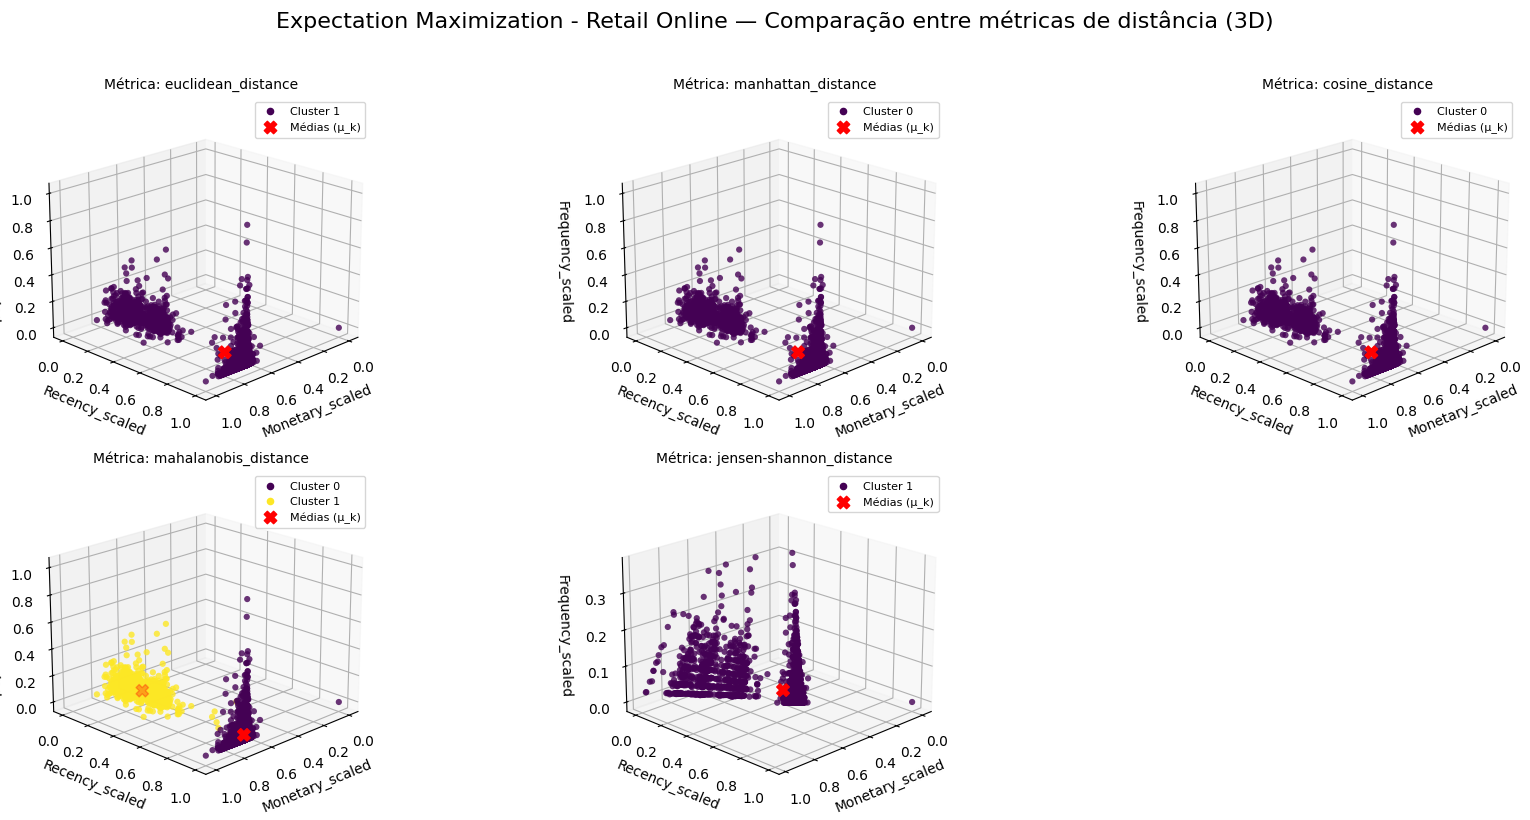

In [166]:
plot_algorithm_all_metrics_3d(plot_dict=plots_em, algorithm_name="Expectation Maximization - Retail Online", x_index=2, y_index=0, z_index=1,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [167]:
#results_em.pop()
df_results_em = pd.DataFrame(results_em)
df_results_em

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,Expectation Maximization,euclidean_distance,1,0.177227,412.467585,NaN,NaN,NaN
1,Expectation Maximization,manhattan_distance,1,0.281476,412.467585,NaN,NaN,NaN
2,Expectation Maximization,cosine_distance,1,0.230832,412.467585,NaN,NaN,NaN
3,Expectation Maximization,mahalanobis_distance,2,0.005300,41.575479,0.872709,0.251674,40313.700727
4,Expectation Maximization,jensen-shannon_distance,1,2.325714,155.884390,NaN,NaN,NaN


In [169]:
labels_em_euclidean = plots_em['euclidean_distance']["labels"]
labels_em_manhattan = plots_em['manhattan_distance']["labels"]
labels_em_cosine = plots_em['cosine_distance']["labels"]
labels_em_mahalanobis = plots_em['mahalanobis_distance']["labels"]
labels_em_jsd = plots_em['jensen-shannon_distance']["labels"]

rfm_em = rfm_full.copy()
rfm_em[f"cluster_em_euclidean"] = labels_em_euclidean
rfm_em[f"cluster_em_manhattan"] = labels_em_manhattan
rfm_em[f"cluster_em_cosine"] = labels_em_cosine
rfm_em[f"cluster_em_mahalanobis"] = labels_em_mahalanobis
rfm_em[f"cluster_em_jsd"] = labels_em_jsd
rfm_em.head()

,Recency,Frequency,M_balance,R_norm,F_norm,M_norm,y,age,housing,marital,education,cluster_em_euclidean,cluster_em_manhattan,cluster_em_cosine,cluster_em_mahalanobis,cluster_em_jsd
0,872,1,8.537388,1.000000,0.000000,0.745264,0,30,0,married,primary,1,0,0,0,1
1,339,5,9.000113,0.388060,0.081633,0.789227,0,33,1,married,secondary,1,0,0,1,1
2,330,2,8.447843,0.377727,0.020408,0.736757,0,35,1,single,tertiary,1,0,0,1,1
3,872,4,8.474494,1.000000,0.061224,0.739289,0,30,1,married,tertiary,1,0,0,0,1
4,872,1,8.106213,1.000000,0.000000,0.704299,0,59,1,married,secondary,1,0,0,0,1


In [170]:
cluster_profile_em_mahalanobis = (
    rfm_em
    .groupby(f"cluster_em_mahalanobis")
    .agg(
        n_contatos=("Recency", "size"),              # quantidade de linhas/contatos no cluster
        recency_media=("Recency", "mean"),
        recency_mediana=("Recency", "median"),
        freq_media=("Frequency", "mean"),
        freq_mediana=("Frequency", "median"),
        monetary_medio=("M_balance", "mean"),
        monetary_mediana=("M_balance", "median"),
        potencial_total=("M_balance", "sum"),          # soma do "M" do cluster
        taxa_conversao=("y", "mean"),          # proporção de y=1
        taxa_housing=("housing", "mean"), # proporção de clientes com housing=1
        idade_media=("age", "mean"),
        idade_mediana=("age", "median"),
        taxa_casados=("marital", lambda x: (x == "married").mean()),
        taxa_unicos=("marital", lambda x: (x == "single").mean()),
        taxa_ensino_superior=("education", lambda x: (x.isin(["tertiary", "university"])).mean())
    )
    .sort_values("monetary_medio", ascending=False)
)

cluster_profile_em_mahalanobis["perc_contatos"] = (
    cluster_profile_em_mahalanobis["n_contatos"] 
    / cluster_profile_em_mahalanobis["n_contatos"].sum()
)

cluster_profile_em_mahalanobis["perc_potencial"] = (
    cluster_profile_em_mahalanobis["potencial_total"] 
    / cluster_profile_em_mahalanobis["potencial_total"].sum()
)

cluster_profile_em_mahalanobis

,n_contatos,recency_media,recency_mediana,freq_media,freq_mediana,monetary_medio,monetary_mediana,potencial_total,taxa_conversao,taxa_housing,idade_media,idade_mediana,taxa_casados,taxa_unicos,taxa_ensino_superior,perc_contatos,perc_potencial
cluster_em_mahalanobis,,,,,,,,,,,,,,,,,
1,815,224.072393,189.0,5.024540,4.0,8.409777,8.279951,6853.968577,0.225767,0.633129,41.553374,39.0,0.603681,0.293252,0.325153,0.18027,0.181171
0,3706,871.999730,872.0,2.964922,2.0,8.358746,8.224164,30977.513814,0.090934,0.551268,41.085807,39.0,0.621964,0.258230,0.292768,0.81973,0.818829


### Algoritmo: Ward

In [ ]:
results_ward = []
plots_ward = {}
# instaciando the Ward Method
for metric_name in metrics:
    ward = WardMethod(k=2, metric=metric_name)
    if metric_name == 'jensen-shannon_distance':
        t0 = time()
        labels_ward = ward.fit_predict(X_jsd)
        runtime_ward = time() - t0
        results_ward.append(calculate_clustering_metrics(algorithm_name="Ward Method", metric_name=metric_name, runtime=runtime_ward, X=X_jsd, labels=labels_ward))
        plots_ward[metric_name] = {
            "X": X_jsd,
            "labels": labels_ward,
            "model": ward
        }
    else:
        t0 = time()
        labels_ward = ward.fit_predict(X)
        runtime_ward = time() - t0
        results_ward.append(calculate_clustering_metrics(algorithm_name="Ward Method", metric_name=metric_name, runtime=runtime_ward, X=X, labels=labels_ward))
        plots_ward[metric_name] = {
            "X": X,
            "labels": labels_ward,
            "model": ward
        }
    print(f"Ward Method com métrica {metric_name} finalizado.")


In [ ]:
plot_algorithm_all_metrics_3d(plot_dict=plots_kmedoids, algorithm_name="K-Medoids - Retail Online", x_index=0, y_index=1, z_index=2,
    n_cols=3, figsize=(18, 8), feature_names=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], elev=20, azim=45,
)

In [ ]:
#results_ward.pop()
df_results_ward = pd.DataFrame(results_ward)
df_results_ward

In [ ]:
ward_euc = plots_ward["euclidean_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)

In [ ]:
ward_euc = plots_ward["manhattan_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)

In [ ]:
ward_euc = plots_ward["mahalanobis_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)

In [ ]:
ward_euc = plots_ward["cosine_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)

In [ ]:
ward_euc = plots_ward["jensen-shannon_distance"]["model"]
ward_euc.plot_dendrogram(truncate_mode='lastp', p=20)